<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Sample-Training-Stimuli" data-toc-modified-id="Sample-Training-Stimuli-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Sample Training Stimuli</a></span></li><li><span><a href="#Visualize-Conditions" data-toc-modified-id="Visualize-Conditions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Visualize Conditions</a></span></li><li><span><a href="#Run-Function-Learning-Task" data-toc-modified-id="Run-Function-Learning-Task-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Run Function-Learning Task</a></span></li><li><span><a href="#Save-Simulated-Data" data-toc-modified-id="Save-Simulated-Data-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Save Simulated Data</a></span></li><li><span><a href="#Plot-Movements-in-Space" data-toc-modified-id="Plot-Movements-in-Space-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Plot Movements in Space</a></span></li><li><span><a href="#True-y-Value-vs.-Size-of-Change" data-toc-modified-id="True-y-Value-vs.-Size-of-Change-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>True y Value vs. Size of Change</a></span></li><li><span><a href="#Local-Change-vs.-Size-of-Change" data-toc-modified-id="Local-Change-vs.-Size-of-Change-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Local Change vs. Size of Change</a></span></li><li><span><a href="#Prediction-Uncertainty-vs.-Size-of-Change" data-toc-modified-id="Prediction-Uncertainty-vs.-Size-of-Change-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Prediction Uncertainty vs. Size of Change</a></span></li><li><span><a href="#Correlations-Between-Movements-in-Different-Conditions" data-toc-modified-id="Correlations-Between-Movements-in-Different-Conditions-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Correlations Between Movements in Different Conditions</a></span></li><li><span><a href="#Plot-Changes-in-Uncertainty" data-toc-modified-id="Plot-Changes-in-Uncertainty-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Plot Changes in Uncertainty</a></span></li></ul></div>

In [1]:
from functools import reduce, partial
from itertools import repeat
from datetime import date
import sys
import multiprocessing
import pickle

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from tqdm.notebook import tqdm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

sys.path.append("..")

In [2]:
# home-grown modules
import py_utils.utils as utils
import py_utils.plotting as plot_utils

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
plt.style.use("seaborn-whitegrid")
sns.set_style("whitegrid")

In [5]:
plt.style.use("presentation.mplstyle")

In [74]:
dict_variables = dict({
    "condition" : ["smooth", "rough"],
    "prior_sd" : [.5],
    "sampling" : ["improvement"], # "metropolis-hastings", 
    "constrain_space" : [False], # True, 
    "space_edge_min" : [0],
    "space_edge_max" : [12],
    "n_features" : [2],
    "n_training" : [int(12**2/4)],
    "n_runs" : [100]
})

In [75]:
df_info, l_info, l_titles = utils.simulation_conditions(dict_variables)

In [76]:
df_info

,condition,prior_sd,sampling,constrain_space,space_edge_min,space_edge_max,n_features,n_training,n_runs,length_scale
0,smooth,0.5,improvement,False,0,12,2,36,100,3
1,rough,0.5,improvement,False,0,12,2,36,100,1


# Sample Training Stimuli

In [77]:
make_stimuli_partial = partial(utils.make_stimuli, map_to_reward=True)
l_df_xy = list(map(make_stimuli_partial, l_info))

# Visualize Conditions

In [78]:
l_df_xy[0], l_ivs, scaler = utils.scale_ivs(l_df_xy[0])
df_train1, df_test1 = utils.split_train_test(l_info[0], l_df_xy[0])
m_gp1 = utils.fit_on_train(df_train1, l_ivs, l_info[0], fit_length_scale=False)
m_gp1.kernel_.length_scale

3

In [79]:
l_df_xy[1], l_ivs, scaler = utils.scale_ivs(l_df_xy[1])
df_train2, df_test2 = utils.split_train_test(l_info[1], l_df_xy[1])
m_gp2 = utils.fit_on_train(df_train2, l_ivs, l_info[1], fit_length_scale=False)
m_gp2.kernel_.length_scale

1

In [80]:
utils.predict_on_test(df_test1, m_gp1, l_ivs).head()

,stim_id,x_1,x_2,y,trial_nr,x_1_z,x_2_z,y_pred_mn,y_pred_sd
0,0,0.0,0.0,3.0,0,-1.593255,-1.593255,-90.255201,0.000649
1,1,0.0,1.0,-3.0,0,-1.593255,-1.303572,-30.901681,0.000188
3,3,0.0,3.0,-14.0,0,-1.593255,-0.724207,-12.358395,0.000047
4,4,0.0,4.0,-18.0,0,-1.593255,-0.434524,-26.036574,0.000061
5,5,0.0,5.0,-19.0,0,-1.593255,-0.144841,-37.195448,0.000089


In [81]:
utils.predict_on_test(df_test2, m_gp2, l_ivs).head()

,stim_id,x_1,x_2,y,trial_nr,x_1_z,x_2_z,y_pred_mn,y_pred_sd
0,0,0.0,0.0,17.0,0,-1.593255,-1.593255,1380.852659,0.119414
1,1,0.0,1.0,12.0,0,-1.593255,-1.303572,594.648940,0.039329
3,3,0.0,3.0,7.0,0,-1.593255,-0.724207,-105.275079,0.007758
4,4,0.0,4.0,-1.0,0,-1.593255,-0.434524,86.809114,0.018928
5,5,0.0,5.0,-2.0,0,-1.593255,-0.144841,257.584816,0.033806


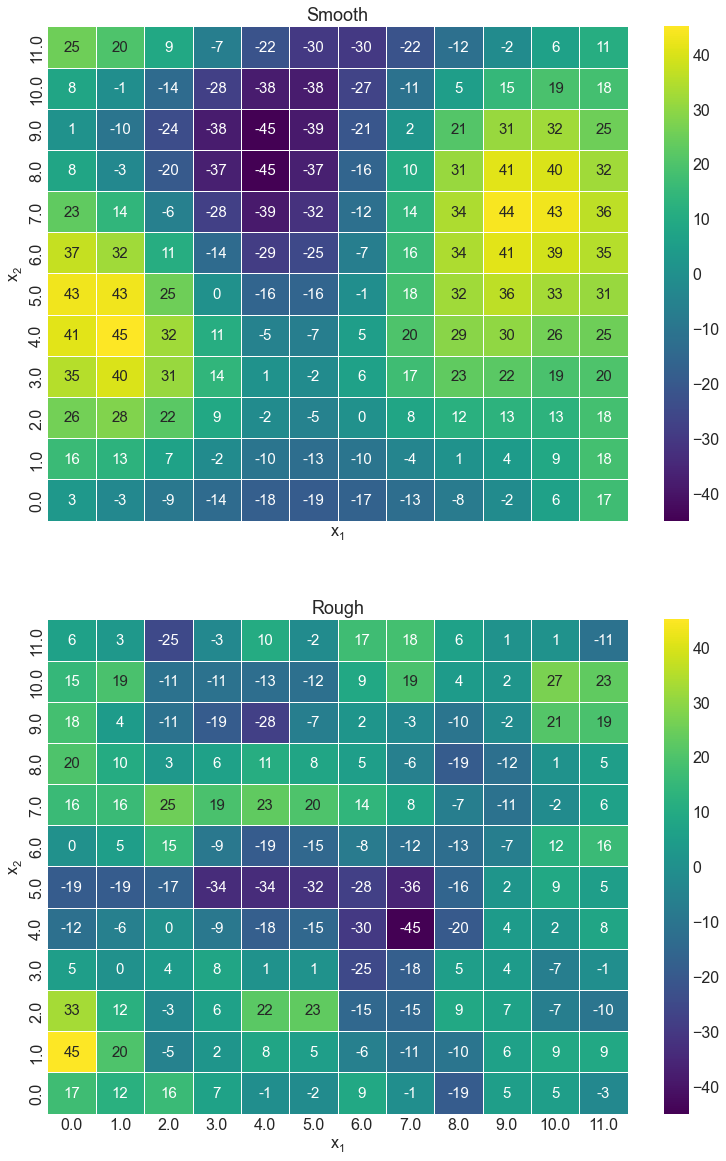

In [82]:
plot_utils.plot_heatmaps(l_info, map_to_reward=True)